# 1 - Simple Sentiment Analysis

In this series we'll be building a machine learning model to detect sentiment (i.e. detect if a sentence is positive or negative) using PyTorch and TorchText. This will be done on movie reviews, using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

## Preparing Data

One of the main concepts of TorchText is the `Field`. These define how your data should be processed. In our sentiment classification task the data consists of both the raw string of the review and the sentiment, either "pos" or "neg".
We use the `TEXT` field to define how the review should be processed, and the `LABEL field` to process the sentiment. 

In [0]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#tokenize all reviews
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

The following code automatically downloads the IMDb dataset and splits it into the train/test splits as `torchtext.datasets` objects. It process the data using the `Fields` we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 43.2MB/s]


We can see how many examples are in each split by checking their length.

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


We can also check an example.

In [4]:
print(vars(train_data.examples[0]))

{'text': ['This', 'is', 'an', 'absurdist', 'dark', 'comedy', 'from', 'Belgium', '.', 'Shot', 'perfectly', 'in', 'crisp', 'black', 'and', 'white', ',', 'Benoît', 'Poelvoorde', '(', 'Man', 'Bites', 'Dog', ')', 'is', 'on', 'fine', 'form', 'as', 'Roger', ',', 'the', 'angry', ',', 'obsessive', 'father', 'of', 'a', 'family', 'in', 'a', 'small', ',', 'sullen', 'Belgian', 'mining', 'town', '.', 'Roger', 'is', 'a', 'photographer', 'who', ',', 'along', 'with', 'his', 'young', 'daughter', 'Luise', ',', 'visits', 'road', 'accidents', 'to', 'take', 'photos', '.', 'He', 'is', 'also', 'obsessed', 'with', 'winning', 'a', 'car', 'by', 'entering', 'a', 'competition', 'where', 'the', 'contestant', 'has', 'to', 'break', 'a', 'record', '-', 'and', 'he', 'decides', 'that', 'his', 'son', ',', 'Michel', ',', 'must', 'attempt', 'to', 'break', 'the', 'record', 'of', 'perpetually', 'walking', 'through', 'a', 'door', '-', 'he', 'even', 'hires', 'an', 'overweight', 'coach', 'to', 'train', 'him', '.', 'Michel', 'dr

The IMDb dataset only has train/test splits, but we want to create a validation set. We can do this with the `.split()` method. 
We also pass our random seed to the `random_state` argument, ensuring that we get the same train/validation split each time.

In [0]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


Next, we have to build a _vocabulary_. We'll use a one-hot vector for every token. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of words in your vocabulary, commonly denoted by $V$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment5.png?raw=1)

The number of words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow and possibly won't fit onto your GPU (if you're using one). 
We'll do the former, only keeping the top 25,000 words, and ignore that appear less than it times.
What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special _unknown_ or `<unk>` token. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


Why is the vocab size 25002 and not 25000? One of the addition tokens is the `<unk>` token and the other is a `<pad>` token.
When we feed sentences into our model, we feed a _batch_ of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment6.png?raw=1)

In [9]:
#We can view the most common words in the vocabulary and their frequencies.
print(TEXT.vocab.freqs.most_common(20))

[('the', 202199), (',', 192008), ('.', 164883), ('and', 109013), ('a', 108776), ('of', 100549), ('to', 93444), ('is', 76157), ('in', 60942), ('I', 54298), ('it', 53374), ('that', 49063), ('"', 44977), ("'s", 43047), ('this', 42438), ('-', 36729), ('/><br', 35714), ('was', 35034), ('as', 30420), ('with', 29874)]


We can also see the vocabulary directly using either the `stoi` (**s**tring **to** **i**nt) or `itos` (**i**nt **to**  **s**tring) method.

In [10]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


We can also check the labels, ensuring 0 is for negative and 1 is for positive.

In [11]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f156495e2f0>, {'neg': 0, 'pos': 1})


The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.
We'll use a `BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.
We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate. 
The embedding layer is used to transform our sparse one-hot vector into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space. 
The RNN layer is our RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, $h_t$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)

Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.
Each batch, `text`, is a tensor of size _**[sentence length, batch size]**_. That is a batch of sentences, each having each word converted into a one-hot vector. 
You may notice that this tensor should have another dimension due to the one-hot vectors, however PyTorch conveniently stores a one-hot vector as it's index value, i.e. the tensor representing a sentence is just a tensor of the indexes for each token in that sentence. The act of converting a list of tokens into a list of indexes is commonly called *numericalizing*.
The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. `embedded` is a tensor of size _**[sentence length, batch size, embedding dim]**_.
`embedded` is then fed into the RNN. If no initial hidden state is passed as an argument it defaults to a tensor of all zeros.
The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1. 
Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

The input dimension is the dimension of the one-hot vectors, which is equal to the vocabulary size. 
The embedding dimension is the size of the dense word vectors. This is usually around 50-250 dimensions/
The hidden dimension is the size of the hidden states. This is usually around 100-500 dimensions.
The output dimension is usually the number of classes, however in the case of only 2 classes the output value is between 0 and 1 and thus can be 1-dimensional, i.e. a single scalar real number.

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

Let's also create a function that will tell us how many trainable parameters our model has so we can compare the number of parameters across different models.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,105 trainable parameters


## Train the Model

In [0]:
import torch.optim as optim

#optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=0.001)

The loss function here is _binary cross entropy with logits_. 
Our model currently outputs an unbound real number. As our labels are either 0 or 1, we want to restrict the predictions to a number between 0 and 1. We do this using the _sigmoid_ or _logit_ functions. 
We then use this this bound scalar to calculate the loss using binary cross entropy. 
The `BCEWithLogitsLoss` criterion carries out both the sigmoid and the binary cross entropy steps.

In [0]:
criterion = nn.BCEWithLogitsLoss()

We can place the model and the criterion on the GPU (if we have one). 

In [0]:
model = model.to(device)
criterion = criterion.to(device)

Our criterion function calculates the loss, however we have to write our function to calculate the accuracy. 
We then calculate how many rounded predictions equal the actual labels and average it across the batch.

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

The `train` function iterates over all examples, one batch at a time. 
`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.
We then feed the batch of sentences, `batch.text`, into the model. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.
The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.
Finally, we return the loss and accuracy, averaged across the epoch. The `len` of an iterator is the number of batches in the iterator.
You may recall when initializing the `LABEL` field, we set `dtype=torch.float`. This is because TorchText sets tensors to be `LongTensor`s by default, however our criterion expects both inputs to be `FloatTensor`s. Setting the `dtype` to be `torch.float`, did this for us.

In [0]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.
`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_.
No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.
The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We'll also create a function to tell us how long an epoch takes to compare training times between models.

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.
At each epoch, if the validation loss is the best we have seen so far, we'll save the parameters of the model and then after training has finished we'll use that model on the test set.

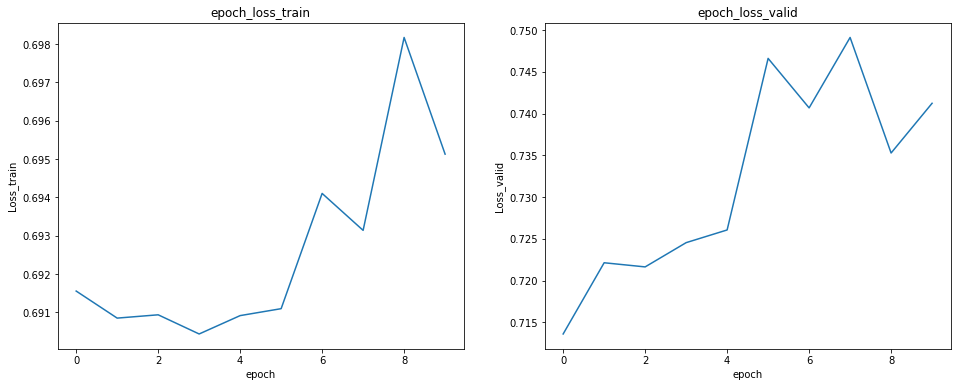

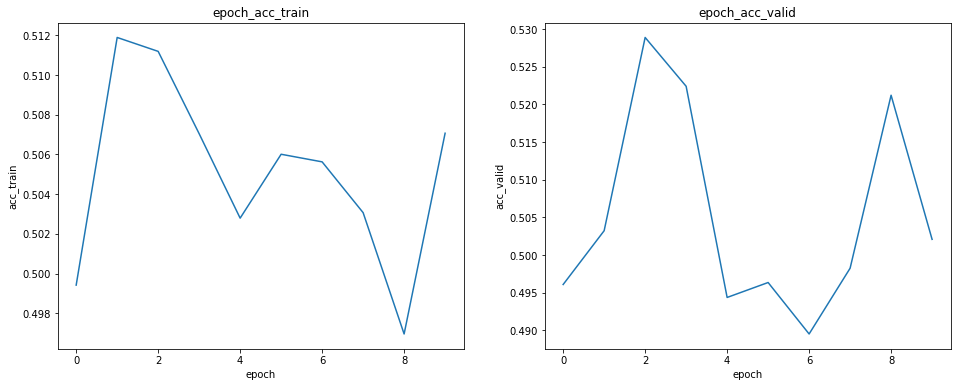

Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 0.695 | Train Acc: 50.71%
	 Val. Loss: 0.741 |  Val. Acc: 50.21%


In [49]:
N_EPOCHS = 10
lst_loss_train = []
lst_loss_valid = []
lst_acc_train = []
lst_acc_valid = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    lst_loss_train.append(train_loss)
    lst_loss_valid.append(valid_loss)
    lst_acc_train.append(train_acc)
    lst_acc_valid.append(valid_acc)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    clear_output(True)
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)   
    plt.plot(lst_loss_train)
    plt.title("epoch_loss_train")
    plt.xlabel("epoch")
    plt.ylabel("Loss_train")
    
    plt.subplot(1, 2, 2)   
    plt.plot(lst_loss_valid)
    plt.title("epoch_loss_valid")
    plt.xlabel("epoch")
    plt.ylabel("Loss_valid")
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)   
    plt.plot(lst_acc_train)
    plt.title("epoch_acc_train")
    plt.xlabel("epoch")
    plt.ylabel("acc_train")

    plt.subplot(1, 2, 2)   
    plt.plot(lst_acc_valid)
    plt.title("epoch_acc_valid")
    plt.xlabel("epoch")
    plt.ylabel("acc_valid")
    plt.show()

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

You may have noticed the loss is not really decreasing and the accuracy is poor. This is due to several issues with the model which we'll improve in the next notebook.
Finally, the metric we actually care about, the test loss and accuracy, which we get from our parameters that gave us the best validation loss.

In [50]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.674 | Test Acc: 60.43%
